# 필요한 라이브러리 로딩

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# GPT 코드

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 사용자 정의 Dataset 클래스
class BikeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        # Convert pandas Series to NumPy array before creating a tensor
        self.y = torch.FloatTensor(y.values) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# 신경망 모델 정의
class BikeNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BikeNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.relu(self.layer3(x)))
        x = self.layer4(x)
        return x.squeeze()

# 데이터 전처리 함수
def preprocess_data():
    # 데이터 불러오기
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    # datetime 처리
    for df in [train, test]:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
        df['dayofweek'] = df['datetime'].dt.dayofweek

    features = ['season', 'holiday', 'workingday', 'weather', 'temp',
               'atemp', 'humidity', 'windspeed', 'year', 'month',
               'day', 'hour', 'dayofweek']

    return train[features], train['count'], test[features]

# 학습 함수
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# 검증 함수
def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def main():
    # 데이터 전처리
    X, y, X_test = preprocess_data()

    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # 데이터셋 및 데이터로더 생성
    train_dataset = BikeDataset(X_train, y_train)
    val_dataset = BikeDataset(X_val, y_val)
    test_dataset = BikeDataset(X_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 초기화
    model = BikeNeuralNetwork(input_dim=X.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    num_epochs = 500
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss = validate_model(model, val_loader, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 테스트 데이터 예측
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())



    # 제출 파일 생성
    submission = pd.DataFrame({
    'datetime': pd.to_datetime(pd.read_csv('test.csv')['datetime']).dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': predictions
    })
    submission.to_csv('submission_04.csv', index=False)
    print('제출 파일이 생성되었습니다.')

if __name__ == '__main__':
    main()

Epoch [10/500], Train Loss: 17633.6630, Val Loss: 15344.0069
Epoch [20/500], Train Loss: 12926.4860, Val Loss: 10783.5206
Epoch [30/500], Train Loss: 11597.2520, Val Loss: 9976.0461
Epoch [40/500], Train Loss: 10585.7223, Val Loss: 8451.7947
Epoch [50/500], Train Loss: 9756.6831, Val Loss: 7487.6962
Epoch [60/500], Train Loss: 8686.2352, Val Loss: 6070.0796
Epoch [70/500], Train Loss: 8118.3749, Val Loss: 6082.4924
Epoch [80/500], Train Loss: 7099.9380, Val Loss: 4790.3186
Epoch [90/500], Train Loss: 7774.8998, Val Loss: 4180.5840
Epoch [100/500], Train Loss: 6539.2243, Val Loss: 3929.9038
Epoch [110/500], Train Loss: 5852.8626, Val Loss: 3378.2766
Epoch [120/500], Train Loss: 5370.2205, Val Loss: 2891.6566
Epoch [130/500], Train Loss: 5103.8636, Val Loss: 3160.4810
Epoch [140/500], Train Loss: 4552.5847, Val Loss: 2601.0167
Epoch [150/500], Train Loss: 4517.8360, Val Loss: 2665.3398
Epoch [160/500], Train Loss: 4336.5032, Val Loss: 2641.8147
Epoch [170/500], Train Loss: 4225.6995, Val

# 테이블 분석

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sampleSubmission.csv")

In [9]:
print(train.columns)
len(train.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


12

In [8]:
print(test.columns)
len(test.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


9

| Column | Description |
|---------|-------------|
| Datetime | 시간 (YYYY-MM-DD 00:00:00) |
| Season | 봄(1) 여름(2) 가을(3) 겨울(4) |
| Holiday | 공휴일(1) 그외(0) |
| Workingday | 근무일(1) 그외(0) |
| Weather | 아주깨끗한날씨(1) 약간의 안개와 구름(2) 약간의 눈,비(3) 아주많은비와 우박(4) |
| Temp | 온도(섭씨로 주어짐) |
| Atemp | 체감온도(섭씨로 주어짐) |
| Humidity | 습도 |
| Windspeed | 풍속 |
| Casual | 비회원의 자전거 대여량 |
| Registered | 회원의 자전거 대여량 |
| Count | 총 자전거 대여량 (비회원+회원) |

train 에는 count 변수가 있지만 test에는 없으니 예측할 값은 count

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.info()

In [32]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek

# test도 변환
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek

# 범주형 데이터 시각화

<Axes: xlabel='year', ylabel='count'>

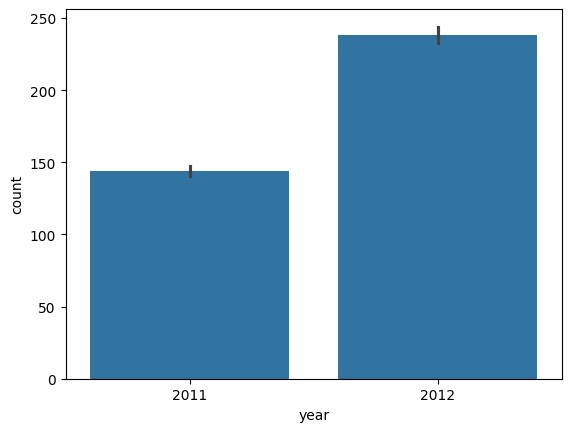

In [39]:
# 년도별 총 대여량
sns.barplot(data = train, x = 'year', y = 'count')

<Axes: xlabel='month', ylabel='count'>

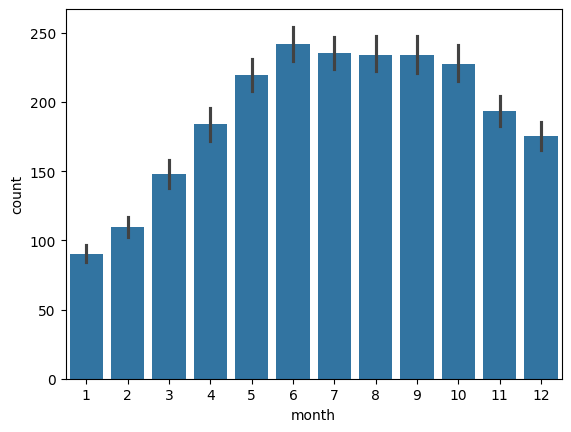

In [40]:
# 월별 총 대여량
sns.barplot(data = train, x = 'month', y = 'count')

<Axes: xlabel='day', ylabel='count'>

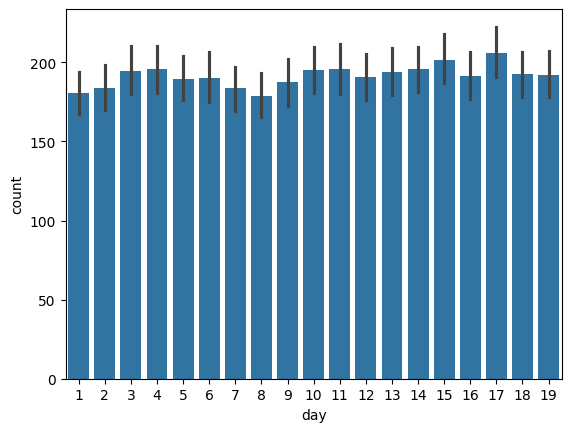

In [41]:
# 일별 총 대여량
sns.barplot(data = train, x = 'day', y = 'count')

<Axes: xlabel='season', ylabel='count'>

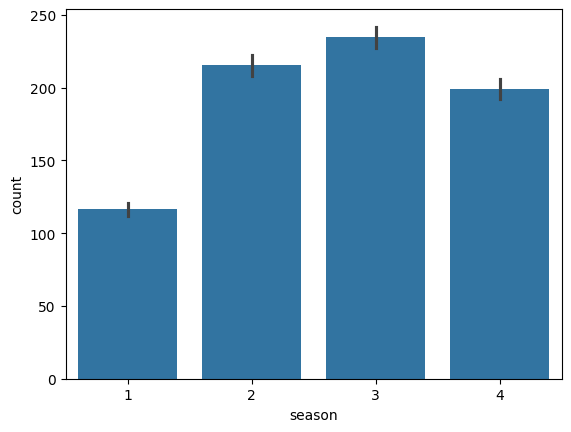

In [42]:
# 계절별 총 대여량
sns.barplot(data = train, x = 'season', y = 'count')
# 1 = [1, 2, 3]월 # 대여량 가장 적은 1, 2, 3월이 1번 변
# 2 = [4, 5, 6]월
# 3 = [7, 8, 9]월
# 4 = [10,11,12]월

<Axes: xlabel='hour', ylabel='count'>

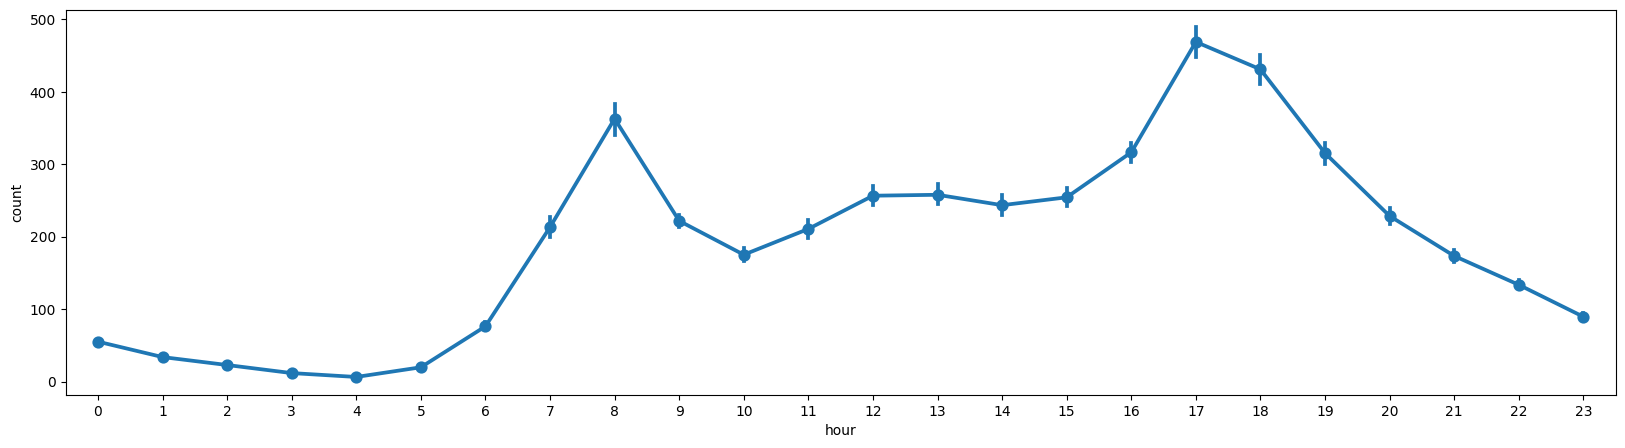

In [43]:
# 시간대별 총 대여량 시각화

fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(20, 5) # 가로,세로

sns.pointplot(data = train, x = 'hour', y = 'count', ax = ax1)

<Axes: xlabel='hour', ylabel='count'>

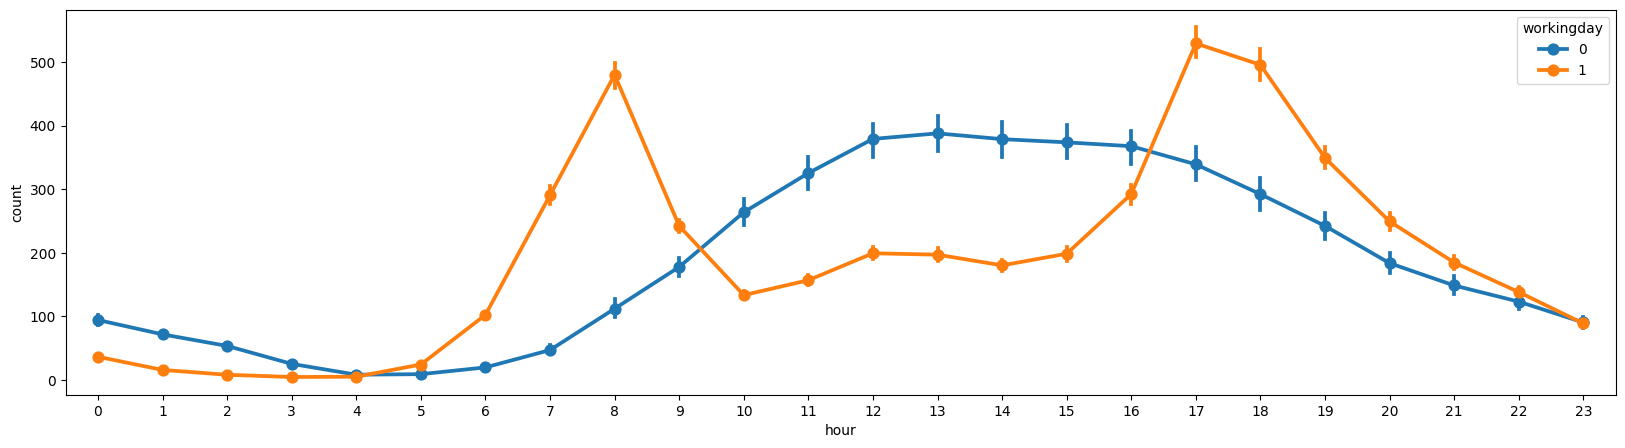

In [44]:
#
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(20, 5)

sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday', ax = ax1)
# workingday = 1, holiday = 0. 시간대별로 카운

# 연속형 데이터 이상치 확인

In [45]:
# 연속형 변수 이상치 확인
numerical = ['temp','atemp', 'humidity', 'windspeed']
train[numerical].describe()
# 일반적으로 풍속과 습도는 0일수 없음.

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


In [80]:
train.windspeed.unique()

array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
        8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
        7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
       40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])

In [48]:
print(train.humidity.unique())

[ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39
  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52
  49  48  37  33  28  38  36  93  29  53  34  54  41  45  92  62  58  61
  60  65  70  27  25  26  31  73  21  24  23  22  19  15  67  10   8  12
  14  13  17  16  18  20  85   0  83  84  78  79  89  97  90  96  91]
[ 0.      6.0032 16.9979 19.0012 19.9995 12.998  15.0013  8.9981 11.0014
 22.0028 30.0026 23.9994 27.9993 26.0027  7.0015 32.9975 36.9974 31.0009
 35.0008 39.0007 43.9989 40.9973 51.9987 46.0022 50.0021 43.0006 56.9969
 47.9988]


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


<Figure size 1200x400 with 0 Axes>

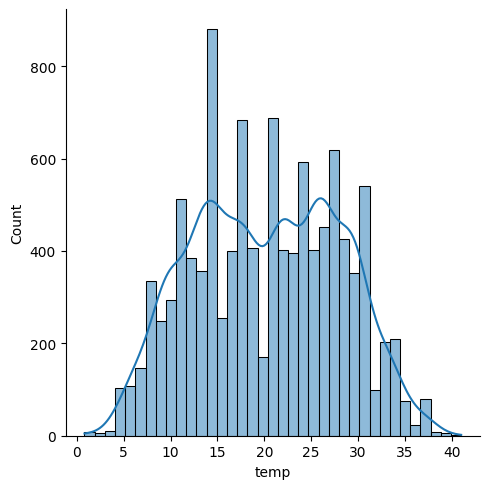

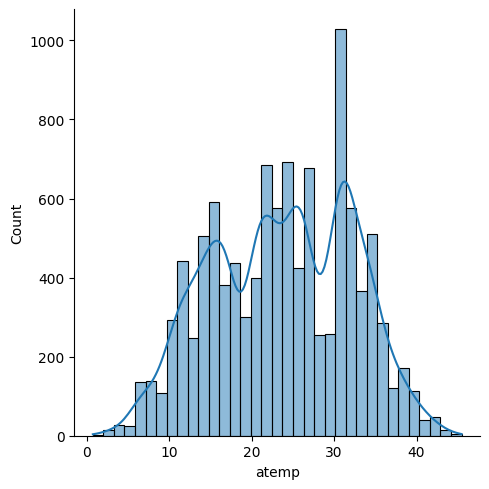

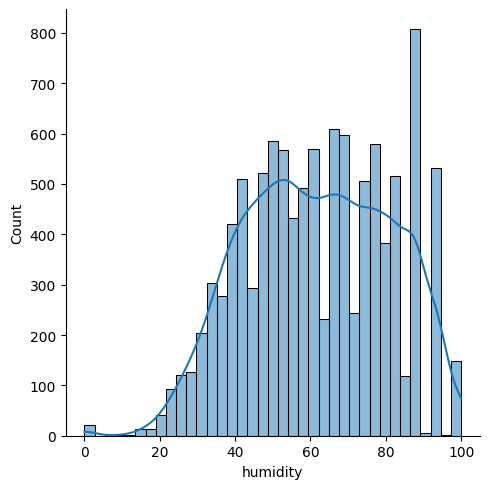

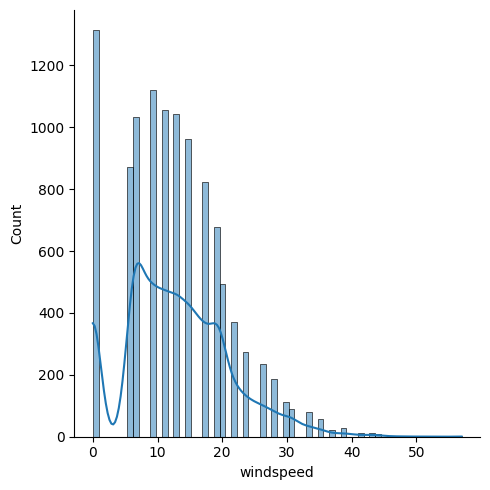

In [81]:
# 4개의 feature에 대한 distplot 그리기
plt.figure(figsize=(12, 4))
# fig, axes = plt.subplots(1, 4, figsize=(12, 4)) # Create subplots first

for i, feature in enumerate(numerical):
    sns.displot(train[feature], kde=True, ax=axes[i]) # Assign plot to the correct axes
    axes[i].set_title(feature) # Set title for each subplot

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

<ipython-input-82-940f8bdc907e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train.atemp_out.fillna(0, inplace=True)


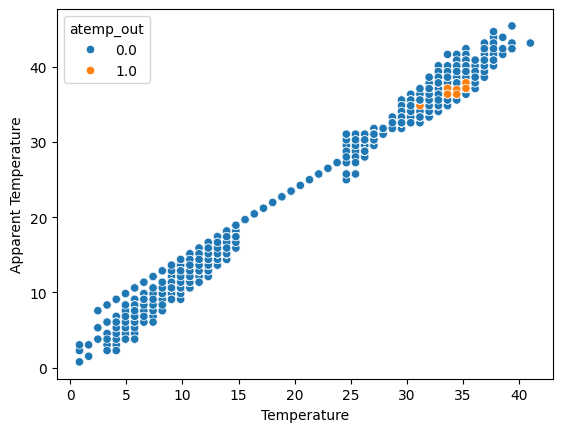

In [82]:
# 이상치 확인
train.loc[train['temp'] / train['atemp'] > 2,'atemp_out'] = 1
train.atemp_out.fillna(0, inplace=True)

sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

In [83]:
train[train.atemp_out == 1]
# atemp 가 12.12로 잘못 기록되어있음

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,atemp_out
8991,2012-08-17 00:00:00,3,0,1,1,27.88,31.82000,57,11.0014,21,67,88,2012,8,17,0,0,0,4,1.0
8992,2012-08-17 01:00:00,3,0,1,1,27.06,31.06000,65,7.0015,16,38,54,2012,8,17,1,0,0,4,1.0
8993,2012-08-17 02:00:00,3,0,1,1,27.06,31.06000,61,8.9981,4,15,19,2012,8,17,2,0,0,4,1.0
8994,2012-08-17 03:00:00,3,0,1,1,26.24,30.30500,65,7.0015,0,6,6,2012,8,17,3,0,0,4,1.0
8995,2012-08-17 04:00:00,3,0,1,1,26.24,30.30500,73,11.0014,0,9,9,2012,8,17,4,0,0,4,1.0
8996,2012-08-17 05:00:00,3,0,1,1,26.24,30.30500,73,7.0015,2,34,36,2012,8,17,5,0,0,4,1.0
8997,2012-08-17 06:00:00,3,0,1,1,25.42,29.54500,78,8.9981,6,151,157,2012,8,17,6,0,0,4,1.0
8998,2012-08-17 07:00:00,3,0,1,1,26.24,30.30500,73,7.0015,11,368,379,2012,8,17,7,0,0,4,1.0
8999,2012-08-17 08:00:00,3,0,1,1,27.88,31.82000,65,8.9981,43,625,668,2012,8,17,8,0,0,4,1.0
9000,2012-08-17 09:00:00,3,0,1,1,28.70,32.57500,58,7.0015,58,320,378,2012,8,17,9,0,0,4,1.0


# Windspeed, atemp 이상치 보완

## atemp 이상치 채우기

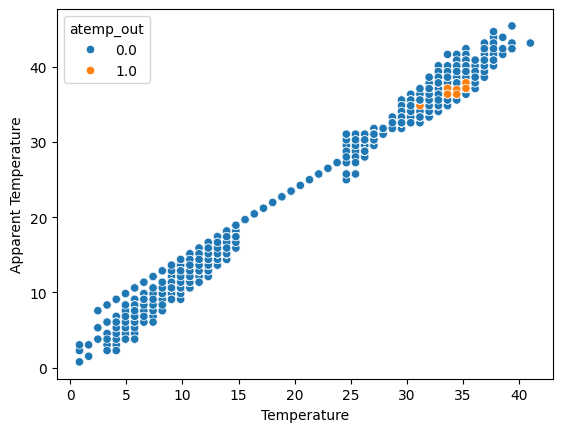

In [68]:
# atemp_out이 1인 데이터의 인덱스를 추출
index_outlier = train[train['atemp_out'] == 1].index

# atemp_out이 0인 데이터를 학습 데이터로 사용
X_train = train[train['atemp_out'] == 0][['temp', 'humidity', 'windspeed','month','hour']]
y_train = train[train['atemp_out'] == 0]['atemp']

# 랜덤 포레스트 모델 생성
model = RandomForestRegressor()

# 모델 학습
model.fit(X_train, y_train)

# atemp_out이 1인 데이터의 온도, 습도, 풍속을 사용하여 체감온도 예측
y_pred = model.predict(train[train['atemp_out'] == 1][['temp', 'humidity', 'windspeed','month','hour']])

# 예측한 체감온도를 train 데이터에 업데이트
train.loc[index_outlier, 'atemp'] = y_pred
sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

## windspeed 이상치 채우기

In [69]:
def fill_windspeed(data):
    # 풍속이 0인/아닌 데이터 분리
    df_wind_0 = data[data['windspeed'] == 0]
    df_wind_not0 = data[data['windspeed'] != 0]

    # 예측에 사용할 피처
    features = ['season', 'weather', 'humidity', 'month', 'temp', 'day', 'hour']

    # Random Forest 모델 학습
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df_wind_not0[features], df_wind_not0['windspeed'])

    # 풍속 0인 데이터 예측
    wind_pred = rf.predict(df_wind_0[features])

    # 예측값으로 대체
    data.loc[data['windspeed'] == 0, 'windspeed'] = wind_pred

    return data

## 시각화로 얻은 정보
    1. 2011년보다 2012년 수요량이 높다
    2. 수요량은 6, 7, 8(여름)에 높고 12, 1, 2월(겨울)에 낮음
    3. 날짜는 큰 영향은 없음
    4. 계절 구분이 123,456,789,101112 임
    5. 8시, 17시(출퇴근)에 자전거 수요량 높음
    6. 근무일은 출퇴근시간에 수요량 높음 / 휴일에는 오후시간에 수요량 높음
    7. 날씨는 1=2 > 3 ... > 4(거의 없음)
## 보완할 부분
    8. temp atemp 한개만 사용? - 다중공선성 문제
    9. windspeed = 0, humidity = 0문제 (일반적으로 풍속과 습도가 0 일수없음)
	    - 값을 어떻게 채워넣을 것인지
    10. 연속형 변수에서 outlier 값 제거
    11. 스케일러 바꾸기(min-max scaling 사용하지만, standardscaler도 좋을듯)
    12. count 값 음수 현상 고치기(로그변환, min-max, 그냥 0으로 대체)

    


# 튜닝 후

In [84]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 사용자 정의 Dataset 클래스
class BikeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# 신경망 모델 정의
class BikeNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BikeNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.relu(self.layer3(x)))
        x = self.layer4(x)
        return x.squeeze()

def fill_windspeed(train):
    # 풍속이 0인/아닌 데이터 분리
    df_wind_0 = train[train['windspeed'] == 0]
    df_wind_not0 = train[train['windspeed'] != 0]

    # 예측에 사용할 피처
    features = ['season', 'weather', 'humidity', 'month', 'temp', 'day', 'hour']

    # Random Forest 모델 학습
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df_wind_not0[features], df_wind_not0['windspeed'])

    # 풍속 0인 데이터 예측
    wind_pred = rf.predict(df_wind_0[features])

    # 예측값으로 대체
    train.loc[train['windspeed'] == 0, 'windspeed'] = wind_pred

    return train

def fill_atemp(train):
    # atemp 이상치 기준 설정 (예: 1분위수 - 1.5*IQR 미만 또는 3분위수 + 1.5*IQR 초과)
    Q1 = train['atemp'].quantile(0.25)
    Q3 = train['atemp'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치에 해당하는 인덱스 저장
    index_atemp = train[(train['atemp'] < lower_bound) | (train['atemp'] > upper_bound)].index



    # 정상 범위의 데이터를 학습 데이터로 사용
    X_train = train[(train['atemp'] >= lower_bound) & (train['atemp'] <= upper_bound)][['season', 'weather', 'temp', 'humidity', 'windspeed', 'month', 'hour']]
    y_train = train[(train['atemp'] >= lower_bound) & (train['atemp'] <= upper_bound)]['atemp']

    # 랜덤 포레스트 모델 생성 및 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 이상치 데이터의 특성을 사용하여 체감온도 예측
    y_pred = model.predict(train.loc[index_atemp, ['season', 'weather', 'temp', 'humidity', 'windspeed', 'month', 'hour']])

    # 예측한 체감온도를 train 데이터에 업데이트
    train.loc[index_atemp, 'atemp'] = y_pred

    return train

# 데이터 전처리 함수
def preprocess_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    # weather_out = train[train['weather'] != 4].copy()

    # datetime 처리
    for df in [train, test]:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
        df['dayofweek'] = df['datetime'].dt.dayofweek

    features = ['season', 'holiday', 'workingday', 'weather', 'temp',
                'atemp','humidity', 'windspeed', 'year', 'month',
               'day', 'hour', 'dayofweek']
    # 제외 :
    return train[features], train['count'], test[features]

# 학습 함수
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# 검증 함수
def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def main():
    # 데이터 전처리
    X, y, X_test = preprocess_data()

    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # 데이터셋 및 데이터로더 생성
    train_dataset = BikeDataset(X_train, y_train)
    val_dataset = BikeDataset(X_val, y_val)
    test_dataset = BikeDataset(X_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 초기화
    model = BikeNeuralNetwork(input_dim=X.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss = validate_model(model, val_loader, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 테스트 데이터 예측
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())



    # 제출 파일 생성
    submission = pd.DataFrame({
    'datetime': pd.to_datetime(pd.read_csv('test.csv')['datetime']).dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': predictions
    })
    submission.to_csv('submission_09.csv', index=False)
    print('제출 파일이 생성되었습니다.')

if __name__ == '__main__':
    main()

Epoch [10/100], Train Loss: 17286.0543, Val Loss: 15476.5486


KeyboardInterrupt: 